# 62-inference-zero-shot-full
> Using built models for inference on the entire dataset

In this notebook, we perform zero-shot classification on our transcripts.  Since at this point in our work, we have access to the full CSV file, we'll use it directly.  Note that for the time being, we **will remove 105-1 and 105-2 because the labels on these transcripts are being reviewed.**

#### Common helpful packages

In [ ]:
#all_no_test
#Data analysis and processing
import pandas as pd

#ml and dl
from transformers import pipeline
from sklearn.metrics import confusion_matrix, classification_report

#plotting
import seaborn as sns

# file system and python operations
import os.path

%matplotlib inline

# Load data
In this section, we're going to use directly load the full CSV of all of the data and use it directly.
#### Filename constants

In [ ]:
# Box prefix (uncomment and use the lower variable if the Box directory on your computer is called "Box Sync")
box_prefix = '~/Box/DSI Documents/'
#box_prefix = '~/Box Sync/DSI Documents/'

# Data filepath
csv_filepath = os.path.expanduser(box_prefix + 'cleaned_data/final_csv.csv')

In [ ]:
#read the csv
transcript_df = pd.read_csv(csv_filepath)

#show the first 5 rows
display(transcript_df.head())

#print size
print('Dimensions of data:', transcript_df.shape, '\n')

#print count info
transcript_df.info()

,id,transcript_filepath,wave_filename,speech,start_timestamp,end_timestamp,label,transcriber_id
0,273-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,today we're talking about the moon.,00:00:00.00,00:01:39.18,NEU,198
1,273-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,so today>,00:00:00.00,00:01:39.18,NEU,198
2,273-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,(fir*) ima see what all you know about the moo...,00:00:00.00,00:01:39.18,NEU,198
3,273-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,we're gonna read about it and find out more ab...,00:00:00.00,00:01:39.18,NEU,198
4,273-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,I'll find out what you know about the moon.,00:00:00.00,00:01:39.18,NEU,198


Dimensions of data: (14021, 8) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14021 entries, 0 to 14020
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   14021 non-null  object
 1   transcript_filepath  14021 non-null  object
 2   wave_filename        14021 non-null  object
 3   speech               14021 non-null  object
 4   start_timestamp      14021 non-null  object
 5   end_timestamp        14021 non-null  object
 6   label                14021 non-null  object
 7   transcriber_id       14021 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 876.4+ KB


Now, we're also going to remove transcripts 105-1 and 105-2 from the processing.

In [ ]:
transcript_df.query("id != '105-1' and id != '105-2'", inplace=True)
transcript_df = transcript_df.reset_index(drop=True)

Let's just quickly check the behavior of this to get updated counts...

In [ ]:
no_teachers = transcript_df['id'].apply(lambda x: x.split('-')[0]).nunique()
no_transcripts = transcript_df['id'].nunique()
no_statements = transcript_df.shape[0]

print('This dataset represents a total of', no_teachers, "teachers recorded...")
print('for a total of', no_transcripts, "transcripts...")
print('with a total of', no_statements, "individual statements.")

This dataset represents a total of 28 teachers recorded...
for a total of 79 transcripts...
with a total of 13743 individual statements.


As you can see in the dataframe above, there are no NaN and everything is looking good.  However, we'll go ahead and add new `sample_id` column for simplicity in the future.

In [ ]:
# Add a column named sample_id with the reset_index trick
transcript_df = transcript_df.reset_index().rename(columns={'index':'sample_id'})
transcript_df.tail()

,sample_id,id,transcript_filepath,wave_filename,speech,start_timestamp,end_timestamp,label,transcriber_id
13738,13738,264-2,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,and I went uhuh.,00:07:11.07,00:10:09.26,NEU,198
13739,13739,264-2,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,you know and I'm backstage.,00:07:11.07,00:10:09.26,NEU,198
13740,13740,264-2,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,you’re trying to get quiet when you're backsta...,00:07:11.07,00:10:09.26,NEU,198
13741,13741,264-2,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,and finally she goes maybe if we clap enough s...,00:07:11.07,00:10:09.26,NEU,198
13742,13742,264-2,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,and I walk out there and I thought if this wom...,00:07:11.07,00:10:09.26,NEU,198


Great.

# Zero-shot classification
Now, we're going to actually perform the zero-shot classification using the text from above.  We'll first declare some parameters and create the zero-shot pipeline for easy modification of the labels and model type.

In [ ]:
# these are the labels that were added to the transcripts (don't change these or the order)
transcript_labels = ['PRS', 'REP', 'NEU', 'OTR']

# define list of candidate labels (change these, but not the order)
candidate_labels = ["positive feedback", "negative feedback", "neutral", "opportunity to respond"]

# define and create pipeline
classifier = pipeline("zero-shot-classification", model='facebook/bart-large-mnli', device=0)

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


Now, we're going to build a dictionary of correspondences using the labels above (which is why we don't change the order).  If you do change the order, just know that the position in one set of labels must have its match at the same position in the other labels.  See below.

We'll use this later to match between our names for the labels (`candidate_labels`) and the transcript labels (`transcript_labels`).

In [ ]:
labels_lookup = dict(zip(candidate_labels, transcript_labels))
labels_lookup

{'positive feedback': 'PRS',
 'negative feedback': 'REP',
 'neutral': 'NEU',
 'opportunity to respond': 'OTR'}

In [ ]:
rev_labels_lookup = dict(zip(transcript_labels, candidate_labels))
rev_labels_lookup

{'PRS': 'positive feedback',
 'REP': 'negative feedback',
 'NEU': 'neutral',
 'OTR': 'opportunity to respond'}

## Make predictions on all transcripts
Now, we'll then use the `speech` column of `transcript_df` to provide inputs to the classifier individually.  Note that we switch from batch here because using the entire batch in one fell swoop requires too much memory for a single GPU resource.

In [ ]:
# Get all the rows of text in the speech column, and convert the data structure into a list.  Use this as the sequences (text) argument to the classifier
# Use the candidate_labels variable we defined above, and use that as the candidate_labels ARGUMENT to the classifier
def get_transformer_classifications(mdl, text_list, label_list):

    #get results in list form
    res = mdl(sequences = text_list,
              candidate_labels = label_list)

    return res

In [ ]:
results_list = [get_transformer_classifications(classifier, text, candidate_labels) for text in transcript_df['speech'].tolist()]

## Convert to a reasonable representation
The results returned are a list of dictionaries.  Each dictionary contains the sequence, the labels, and the probabilities associated with each label.  This will be shown below.  Dictionaries are easily converted to pandas dataframes, where each key becomes a column of the new dataframe.  In the same way, lists of dictionaries are also easily converted to pandas dataframes.

In [ ]:
#make sure it is the right size
len(results_list) #passed

13743

In [ ]:
#look at the first 2 elements of results_list
results_list[:2]

[{'sequence': "today we're talking about the moon.",
  'labels': ['opportunity to respond',
   'positive feedback',
   'neutral',
   'negative feedback'],
  'scores': [0.5531594157218933,
   0.2243356555700302,
   0.12207228690385818,
   0.10043270140886307]},
 {'sequence': 'so today>',
  'labels': ['opportunity to respond',
   'positive feedback',
   'negative feedback',
   'neutral'],
  'scores': [0.42565831542015076,
   0.3490981161594391,
   0.12651561200618744,
   0.09872791171073914]}]

In [ ]:
#example of converting a single element of this list to a dataframe
pd.DataFrame(results_list[0])

,sequence,labels,scores
0,today we're talking about the moon.,opportunity to respond,0.553159
1,today we're talking about the moon.,positive feedback,0.224336
2,today we're talking about the moon.,neutral,0.122072
3,today we're talking about the moon.,negative feedback,0.100433


In [ ]:
#use a list comprehension to generate a list of these dataframes
results_df_list = [pd.DataFrame(result) for result in results_list]

#add the sample_id column for each dataframe
results_df_list = [df.assign(sample_id = ind) for ind, df in enumerate(results_df_list)]

#concatenate this list together to form one single dataframe
results_df = pd.concat(results_df_list)
results_df.head()

,sequence,labels,scores,sample_id
0,today we're talking about the moon.,opportunity to respond,0.553159,0
1,today we're talking about the moon.,positive feedback,0.224336,0
2,today we're talking about the moon.,neutral,0.122072,0
3,today we're talking about the moon.,negative feedback,0.100433,0
0,so today>,opportunity to respond,0.425658,1


In [ ]:
#pivot_wider and take `sequence` off the index
results_df = results_df.pivot(index=['sample_id', 'sequence'], columns='labels', values='scores').reset_index(level='sequence')
results_df

labels,sequence,negative feedback,neutral,opportunity to respond,positive feedback
sample_id,,,,,
0,today we're talking about the moon.,0.100433,0.122072,0.553159,0.224336
1,so today>,0.126516,0.098728,0.425658,0.349098
2,(fir*) ima see what all you know about the moo...,0.334217,0.012606,0.437235,0.215942
3,we're gonna read about it and find out more ab...,0.049091,0.038513,0.830524,0.081872
4,I'll find out what you know about the moon.,0.059459,0.009332,0.859977,0.071232
...,...,...,...,...,...
13738,and I went uhuh.,0.138080,0.114503,0.613215,0.134202
13739,you know and I'm backstage.,0.082442,0.165741,0.605146,0.146671
13740,you’re trying to get quiet when you're backsta...,0.387192,0.027559,0.564811,0.020438


In [ ]:
#get the max of the labels columns (using candidate_labels) and add a column called 'pred_zslabels'
results_df['pred_zslabels'] = results_df[candidate_labels].idxmax(axis=1)

#now we'll use the lookup dictionary we made above to create the pred column to correspond to the real labels
results_df['pred'] = results_df['pred_zslabels'].replace(labels_lookup)

In [ ]:
#now, we'll join on the real labels and some other columns just to make sure things look right
results_df = results_df.merge(transcript_df[['sample_id', 'label', 'speech']], left_index=True, right_on='sample_id')

#there's a current challenge in the data with leading and trailing whitespace so let's make sure to strip that off our labels
results_df['label'] = results_df['label'].str.strip()

#let's rename the 'label' column to be 'truth'
results_df = results_df.rename(columns={'label':'truth'})

#let's look at the first 15 rows of the result
results_df.head(15)

,sequence,negative feedback,neutral,opportunity to respond,positive feedback,pred_zslabels,pred,sample_id,truth,speech
0,today we're talking about the moon.,0.100433,0.122072,0.553159,0.224336,opportunity to respond,OTR,0,NEU,today we're talking about the moon.
1,so today>,0.126516,0.098728,0.425658,0.349098,opportunity to respond,OTR,1,NEU,so today>
2,(fir*) ima see what all you know about the moo...,0.334217,0.012606,0.437235,0.215942,opportunity to respond,OTR,2,NEU,(fir*) ima see what all you know about the moo...
3,we're gonna read about it and find out more ab...,0.049091,0.038513,0.830524,0.081872,opportunity to respond,OTR,3,NEU,we're gonna read about it and find out more ab...
4,I'll find out what you know about the moon.,0.059459,0.009332,0.859977,0.071232,opportunity to respond,OTR,4,NEU,I'll find out what you know about the moon.
5,is that all right?,0.081929,0.094927,0.656277,0.166867,opportunity to respond,OTR,5,NEU,is that all right?
6,no.,0.519304,0.429021,0.042310,0.009365,negative feedback,REP,6,REP,no.
7,just act normal please.,0.085889,0.497757,0.345656,0.070698,neutral,NEU,7,REP,just act normal please.
8,(so) let's see.,0.021734,0.027916,0.875908,0.074442,opportunity to respond,OTR,8,NEU,(so) let's see.
9,name tell me what you know about the moon so far.,0.012012,0.008315,0.948941,0.030732,opportunity to respond,OTR,9,OTR,name tell me what you know about the moon so far.


Great! This looks correct.  Let's start with the performance evaluation.

## Evaluate performance using confusion matrix
Given the structure our results, let's finish up with a confusion matrix.

In [ ]:
#use confusion matrix function from scikit-learn metrics
c_ma = confusion_matrix(results_df['truth'], results_df['pred'], labels=transcript_labels)

In [ ]:
#create a dataframe from the confusion matrix
c_df = pd.DataFrame(c_ma,
                    columns = transcript_labels,
                    index = transcript_labels)

#use reverse lookup table from above to use the actual labels that we assigned for zero shot
c_df.rename(columns=rev_labels_lookup, index=rev_labels_lookup, inplace=True)

#add axis labels for seaborn
c_df.index.name = 'Actual Labels'
c_df.columns.name = 'Predicted Labels'

#inspect
c_df

Predicted Labels,positive feedback,negative feedback,neutral,opportunity to respond
Actual Labels,,,,
positive feedback,1525,9,10,140
negative feedback,37,168,27,277
neutral,1759,1056,278,4796
opportunity to respond,239,140,36,3242


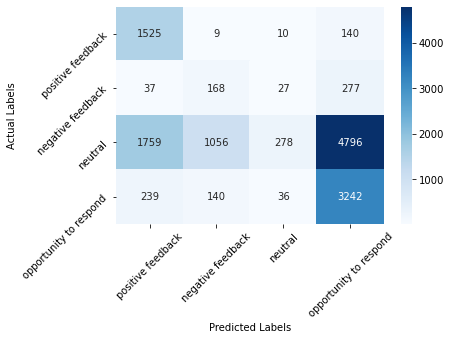

In [ ]:
#use seaborne to display as heatmap
ax = sns.heatmap(c_df, cmap='Blues', annot=True, fmt='d');
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45);
ax.set_yticklabels(ax.get_yticklabels(),rotation = 45);

Let's inspect this confusion matrix.
* It is hard for zero shot to distinguish neutral.  Looking across the row, neutral is incorrectly predicted to be every class, much moreso than it is correctly predicted in general.
* The model is great at classifying OTR and PRS (high sensitivity), but it also tends to assign these classifications heavily (even though they're not as strongly represented in the dataset).

Great steps to improve from here include:
* Training a model to discern between neutral and other classes
* Directly converting the logits to probabilities, and considering examples with target probabilities (i.e., PRS, REP, OTR) lower than a particular threshold to be neutral.
* Inspecting the eyeball set of misclassified samples to identify if there's any similarities or improvements which can be proposed.

# Evaluate Performance Using Classification Report
Here, we'll just use the classification report function from sklearn.  This will return the precision (positive predictive value), recall (sensitivity), and f1 score (harmonic mean of precision and recall) as well as different types of averages to come to a final value.

In [ ]:
perf_metrics = classification_report(results_df.dropna()['truth'], results_df.dropna()['pred'], labels=transcript_labels, target_names = candidate_labels)
print(perf_metrics)

                        precision    recall  f1-score   support

     positive feedback       0.43      0.91      0.58      1684
     negative feedback       0.12      0.33      0.18       509
               neutral       0.79      0.04      0.07      7889
opportunity to respond       0.38      0.89      0.54      3657

             micro avg       0.38      0.38      0.38     13739
             macro avg       0.43      0.54      0.34     13739
          weighted avg       0.61      0.38      0.26     13739



Let's look at this.  We notice a few things in looking at the per-class metrics.
* The support of the averages is 13739, which is 4 less than the total sample size.  This is investigated more below, but essentially boils down to that there are 4 rows where the ground truth labels are incorrectly entered.
* These results frame what we observed in the confusion matrix.  First, we see that PRS and OTR have good-ish sensitivity, but this is clearly at the expense of their associated precision (we predict everything to be this label, so we end up being right a lot!)
* NEU has an absolutely terrible sensitivity - it's almost never predicted.  But when it IS predicted, it's often right!

We also notice a few things in looking at the averages:
* Let's look at the micro average.  Consider the calculation of precision, which is the number that were correctly predicted out of the total number of predicted.  We extend this for all classes such that the numerator is the total number that were correctly predicted and the denominator is the total number of predictions.  This value essentially boils down to the overall accuracy.
* The macro average is taking all of the values for a single metric and just averaging them together, essentially giving equal weight to each of the classes.  This gives us a somewhat clearer picture, in that giving equal weighting to the performance of each class, the recall (sensitivity) is a bit higher - so on average, we do much better than guessing, and our guesses are usually right a little less than half the time.
* The weighted average is just what you'd think - the metric for each class weighted by its support.  On average, our precision is pretty high because most of our data are neutrals, and the ppv on neutrals is high.  The tradeoff becomes clear here: the sensitivity (recall) is much lower because again, NEU is most of the dataset, and only 4% of these NEU were actually correctly identified!  Finally, the low f1 score reflects this tradeoff.

### Quick sanity checks
Here, we'll just do a few quick sanity checks to make sure things look right

In [ ]:
#this should be the total number of rows in the results and transcripts dataframe
c_df.sum().sum() #failed for the reasons below

13739

In [ ]:
#this should be equal to the sum of the rows of the confusion matrix
results_df['truth'].value_counts() #passed

NEU    7889
OTR    3657
PRS    1684
REP     509
NO        1
OTS       1
NUE       1
OT        1
Name: truth, dtype: int64

We see here that there are some errors in the encodings for the labels.  These incorrect rows have been discarded in the computation of the confusion matrix and classification report.  Only the labels provided by the function argument `labels` are used.

In [ ]:
#this should be equal to the sum of the columns of the confusion matrix
results_df['pred'].value_counts() #passed

OTR    8457
PRS    3562
REP    1373
NEU     351
Name: pred, dtype: int64

This again reinforces some of our results from the confusion matrix and the classification report.  We can see that NEU is the most populated class by a factor of 2 above the largest class, and yet it is the least represented in the predictions.  We can see that OTR, REP, and PRS are heavily predicted, despite their ground truth labels representing less than half of the entire dataset in total.